Go to <a href=#bookmark>my bookmark</a>

<a name='bookmark' /> my bookmark

In [1]:
import warnings

warnings.simplefilter("ignore")

import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE



from tpot import TPOTClassifier

In [2]:
# Utility function to report best scores
def report(results, n_top=3):
    """Utility function to report best scores
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Rank: {0}".format(i))
            print("Score: {0:f} (std: {1:f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Pars: {0}".format(results['params'][candidate]))
            print("")
            

def report2(results, n_top=3):
    """Utility function to report best scores
    """
    print("Rank|Score(std)|Params", list(results['params'][0].keys()))
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("{0}|".format(i), end="")
            print("{0:f}(std:{1:f})|".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]), end="")
            print("{0}".format(list(results['params'][candidate].values())))

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

----
# modify features

## fill na of Fare in test data 

missing Fare is Pclass 3 member's fare.
Fill it by Pclass's Fare median 8.05

In [4]:
test_df[test_df.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


## make Family_Survival feature
### fill na of Fare in test data by mean of all data too
https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/


In [5]:
data_df = train_df.append(test_df) # The entire data: train + test.

data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
#data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)
data_df['Fare'].fillna(data_df[data_df.Pclass == 3].Fare.median(), inplace=True)


DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])


Number of passengers with family survival information: 420


In [6]:
data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Last_Name,Family_Survival
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Braund,0.5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Cumings,0.5
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Heikkinen,0.5
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Futrelle,0.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Allen,0.5


In [7]:
data_df.Fare.isna().any()

False

In [8]:
test_df.Fare.isna().any()

True

In [9]:
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
#train_df['Family_Survival'] = data_df['Family_Survival'][:891]
#test_df['Family_Survival'] = data_df['Family_Survival'][891:]

train_df = data_df.iloc[:train_df.shape[0]]
test_df = data_df.iloc[train_df.shape[0]:]

train_df = train_df.drop(['Last_Name'], axis=1)
test_df = test_df.drop(['Last_Name'], axis=1)
combine = [train_df, test_df]

combine = [train_df, test_df]

Number of passenger with family/group survival information: 546


In [10]:
train_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Survival
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0.5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0.5
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0.5
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0.5


In [11]:
train_df.Family_Survival.value_counts()

0.5    516
1.0    205
0.0    170
Name: Family_Survival, dtype: int64

In [12]:
test_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Survival
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911,0.5
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272,0.5
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,NaN,240276,0.5
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,NaN,315154,0.5
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,NaN,3101298,1.0


In [13]:
test_df.Family_Survival.value_counts()

0.5    247
1.0     98
0.0     73
Name: Family_Survival, dtype: int64

<a name='bookmark' /> my bookmark

----

## make ticket length feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [14]:
train_df['Ticket_Len'] = train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_Len'] = test_df['Ticket'].apply(lambda x: len(x))
combine = [train_df, test_df]

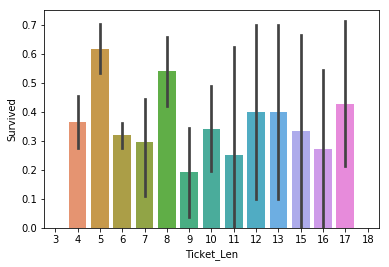

In [15]:
sns.barplot(data=train_df, x="Ticket_Len", y="Survived")

In [16]:
train_df['Ticket_Len'].value_counts(dropna=False)

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

In [17]:
test_df['Ticket_Len'].value_counts(dropna=False)

6     183
5      62
4      47
8      42
10     22
9      11
11     10
13      9
7       9
18      8
12      6
15      3
17      2
16      2
3       2
Name: Ticket_Len, dtype: int64

----

## make Cabin First character feature

In [18]:
train_df["Cabin_Letter"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
test_df["Cabin_Letter"] = test_df["Cabin"].fillna('0').apply(lambda x: x[0])
combine = [train_df, test_df]

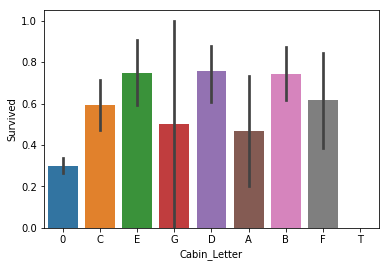

In [19]:
sns.barplot(data=train_df, x="Cabin_Letter", y="Survived")

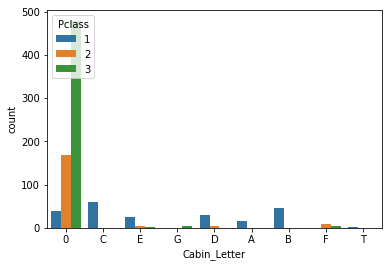

In [20]:
sns.countplot(data=train_df, x="Cabin_Letter", hue="Pclass")

### make one Cabin_Letter feature by numerical

### make dummy variable for Cabin_Letter

In [21]:
train_test_df = pd.concat((train_df, test_df))

# apply get_dummies for Cabin_Letter
train_test_df = pd.get_dummies(train_test_df, columns=["Cabin_Letter"])

train_df = train_test_df.iloc[:train_df.shape[0]]

test_df = train_test_df.iloc[train_df.shape[0]:]
test_df = test_df.drop("Survived", axis=1) # drop added Survived column from test_df

combine = [train_df, test_df]

**if you made Cabin_num features too, duplicate feature for NaN. delete one of these**

----

## make CabinBool feature
**I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. **
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- I tried it
  - but gradient boosting result became worse. from 0.79904 to 0.77990
  - more than cabinbool is necessary? should i use first letter of cabin name?

**CabinBool is inclueded in Cabin letter and cabin number**
**no need to use**

----

## make Cabin number feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [22]:
#for i in [train_df, test_df]:
for i in combine:
    i['Cabin_num'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
    i['Cabin_num'].replace('an', np.NaN, inplace = True)
    i['Cabin_num'] = i['Cabin_num'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)


In [23]:
train_df['Cabin_num_Band'] = pd.qcut(train_df['Cabin_num'], 3)

train_df['Cabin_num_Band'].value_counts(dropna=False) 

#NaN                 691
#(65.667, 148.0]      67
#(1.999, 28.667]      67
#(28.667, 65.667]     66


NaN                 691
(65.667, 148.0]      67
(1.999, 28.667]      67
(28.667, 65.667]     66
Name: Cabin_num_Band, dtype: int64

In [24]:
train_df['Cabin_num_Band'] = train_df['Cabin_num_Band'].cat.add_categories("nan_category")
train_df['Cabin_num_Band'] = train_df['Cabin_num_Band'].fillna("nan_category")


In [25]:
train_df.groupby(["Cabin_num_Band"])["Survived"].value_counts(dropna=False)

Cabin_num_Band    Survived
(1.999, 28.667]   1.0          48
                  0.0          19
(28.667, 65.667]  1.0          43
                  0.0          23
(65.667, 148.0]   1.0          43
                  0.0          24
nan_category      0.0         483
                  1.0         208
Name: Survived, dtype: int64

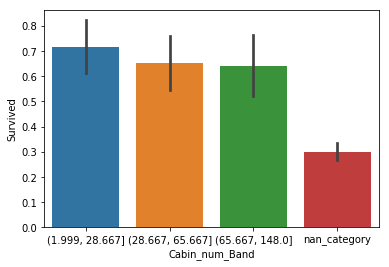

In [26]:
sns.barplot(data=train_df, x="Cabin_num_Band", y="Survived")

In [27]:
# 3 cabin num band
combine = [train_df, test_df]
for dataset in combine:
    dataset.loc[ dataset['Cabin_num'] <= 28.667, 'Cabin_num'] = 0
    dataset.loc[(dataset['Cabin_num'] > 28.667) & (dataset['Cabin_num'] <= 65.667), 'Cabin_num'] = 1
    dataset.loc[ dataset['Cabin_num'] > 65.667, 'Cabin_num'] = 2
combine = [train_df, test_df]


In [28]:
train_df = train_df.drop(['Cabin_num_Band'], axis=1)
combine = [train_df, test_df]

In [29]:
train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix='Cabin_num', dummy_na=True)), axis = 1)
test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix='Cabin_num', dummy_na=True)), axis = 1)
combine = [train_df, test_df]

In [30]:
del train_df['Cabin_num']
del test_df['Cabin_num']
combine = [train_df, test_df]

In [31]:
train_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Survival',
       'Ticket_Len', 'Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B',
       'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F',
       'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0', 'Cabin_num_1.0',
       'Cabin_num_2.0', 'Cabin_num_nan'],
      dtype='object')

----

## del Ticket, Cabin columns

In [32]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

----

## add title

In [33]:
# add title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

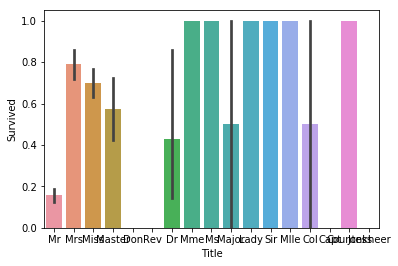

In [34]:
sns.barplot(data=train_df, x="Title", y="Survived")

In [35]:
train_df.Title.value_counts(dropna=False)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Countess      1
Jonkheer      1
Mme           1
Capt          1
Don           1
Ms            1
Sir           1
Lady          1
Name: Title, dtype: int64

----

## make name length feature

In [36]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Len'] = test_df['Name'].apply(lambda x: len(x))
combine = [train_df, test_df]

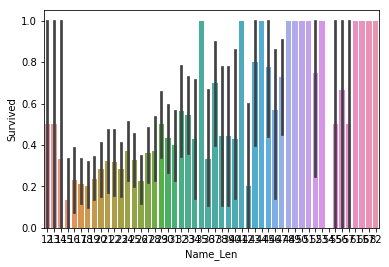

In [37]:
sns.barplot(data=train_df, x="Name_Len", y="Survived")

----

## map value to Sex 

In [38]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)

----

## make Age_Null_Flag if the Age is nulll

In [39]:
train_df['Age_Null_Flag'] = train_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_df['Age_Null_Flag'] = test_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
combine = [train_df, test_df]

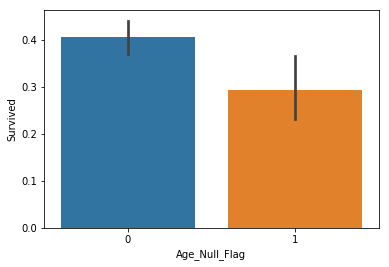

In [40]:
sns.barplot(data=train_df, x="Age_Null_Flag", y="Survived")

In [41]:
train_df["Age_Null_Flag"].value_counts(dropna=False)

0    714
1    177
Name: Age_Null_Flag, dtype: int64

In [42]:
test_df["Age_Null_Flag"].value_counts(dropna=False)

0    332
1     86
Name: Age_Null_Flag, dtype: int64

----

## fill na of Age

options

- by Sex and Pclass
- by Title and Pclass

In [43]:
pd.cut(train_df['Age'], 5).value_counts(dropna=False)

(16.336, 32.252]    346
(32.252, 48.168]    188
NaN                 177
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

### by Sex and Pclass

### fill nan of Age by Title and Pclass
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

There is mistake in the original notebook.
test_df was filled by train_df.
So I modified.

In [44]:
train_test_df = pd.concat((train_df, test_df))

groupedAge_train_test = train_test_df.groupby(['Title', 'Pclass'])['Age']

# fill by title and pclass. 
# but one grouped row doesn't have Age num. 
# So need to group by only Title and fill of the mean value.
train_test_df.Age = groupedAge_train_test.transform(lambda x:x.fillna(x.mean()))

# fill by just title because no value row if group by title and pclass
groupedByTitleOnly_Age_train_test = train_test_df.groupby(['Title'])['Age']
train_test_df.Age = groupedByTitleOnly_Age_train_test.transform(lambda x:x.fillna(x.mean()))

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop(["Survived"], axis=1)

combine = [train_df, test_df]

#### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

**2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.**
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

----

### add age band

- 5 age band by pd.cut
- 10 age band by pd.cut: this is better score.

if i use pd.qcut, band become too short for young adult around 25.

**first, check age band and Survived feature in train_df**

In [45]:
pd.cut(train_df['Age'], 5).value_counts(dropna=False)

(16.336, 32.252]    472
(32.252, 48.168]    235
(0.34, 16.336]      104
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

In [46]:
pd.cut(train_df['Age'], 10).value_counts(dropna=False)

(24.294, 32.252]    260
(16.336, 24.294]    212
(32.252, 40.21]     136
(40.21, 48.168]      99
(0.34, 8.378]        58
(8.378, 16.336]      46
(48.168, 56.126]     45
(56.126, 64.084]     24
(64.084, 72.042]      9
(72.042, 80.0]        2
Name: Age, dtype: int64

In [47]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
combine = [train_df, test_df]

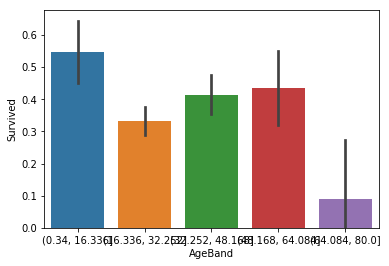

In [48]:
sns.barplot(x="AgeBand", data=train_df, y="Survived")

In [49]:
train_df.groupby(["AgeBand"]).Survived.value_counts()

AgeBand           Survived
(0.34, 16.336]    1.0          57
                  0.0          47
(16.336, 32.252]  0.0         315
                  1.0         157
(32.252, 48.168]  0.0         138
                  1.0          97
(48.168, 64.084]  0.0          39
                  1.0          30
(64.084, 80.0]    0.0          10
                  1.0           1
Name: Survived, dtype: int64

### Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [50]:
# 5 age band
combine = [train_df, test_df]
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

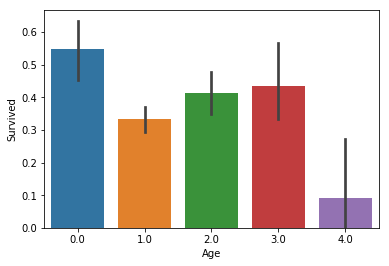

In [51]:
sns.barplot(data=train_df, x="Age", y="Survived")

----

## convert Title to numerical or one hot encoding

several options

1. one hot encoding, no deleting rare title
2. change rare title to "Rare" and map value
  - 2.1. Replacing rare titles with more common ones
3. modify known title to usual, change rare title to "Rare" and one hot encoding

### 1. one hot encoding, no deleteing rare title

### 2. change rare titles to "Rare" and map value

**del rare title and map value**

#### 2.1. Replacing rare titles with more common ones**

https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/

### 3. modify known title to usual, change rare title to "Rare" and one hot encoding

In [52]:
mapping = {'Mlle': 'Miss', 
            'Major': 'Mr', 
            'Col': 'Mr', 
            'Sir': 'Mr',
            'Don': 'Mr', 
            'Mme': 'Miss',
            'Jonkheer': 'Mr',
            'Lady': 'Mrs', 
            'Capt': 'Mr', 
            'Countess': 'Mrs',
            'Ms': 'Miss',
            'Dona': 'Mrs'}

train_df.replace({'Title': mapping}, inplace=True)
test_df.replace({'Title': mapping}, inplace=True)

combine = [train_df, test_df]

train_test_df = pd.concat((train_df, test_df))
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 33) (418, 32)


In [53]:
train_df.columns

Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'Embarked',
       'Family_Survival', 'Fare', 'Name', 'Name_Len', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket_Len', 'Title_Dr',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev'],
      dtype='object')

----

## Create new feature "FamilySize", "IsAlone", "Age*Class"

In [54]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

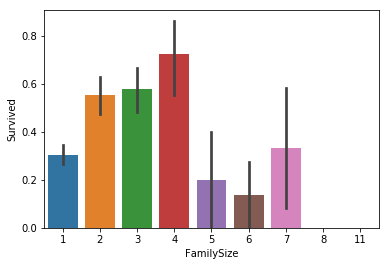

In [55]:
sns.barplot(data=train_df, x="FamilySize", y="Survived")

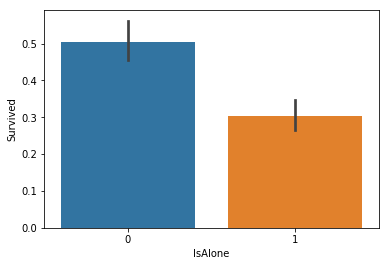

In [56]:
sns.barplot(data=train_df, x="IsAlone", y="Survived")

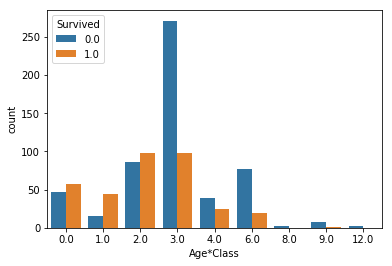

In [57]:
sns.countplot(data=train_df, x="Age*Class", hue="Survived")

----

## fill missing Embarked 

In [58]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

----

## Embarked categorical feature

### 1. Converting Embarked categorical feature to numeric

### 2. one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

In [59]:
train_test_df = pd.concat((train_df, test_df))
train_test_df = pd.get_dummies(train_test_df, columns=["Embarked"])

combine = [train_df, test_df]

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop("Survived", axis=1)

combine = [train_df, test_df]

----

## make Fareband feature

In [60]:
pd.qcut(train_df['Fare'], 4).value_counts(dropna=False)

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: Fare, dtype: int64

In [61]:
test_df.Fare.isna().any()

False

In [62]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    #print(dataset['Fare'].value_counts(dropna=False))
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]

### try more fare band number

- no difference

### keep Fare feature and add FareBand numerical feature¶

- not good result

----

## drop Name, PassengerId

In [63]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

----

## final check data

In [64]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,9,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,16,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1


In [65]:
train_df.columns

Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'FamilySize',
       'Family_Survival', 'Fare', 'IsAlone', 'Name_Len', 'Parch', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket_Len', 'Title_Dr', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [66]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
1,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,0,1,0,0,0,1
2,3.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
3,1.0,3.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1
4,1.0,3.0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,1,0,0,0,1


In [67]:
test_df.columns

Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'FamilySize',
       'Family_Survival', 'Fare', 'IsAlone', 'Name_Len', 'Parch',
       'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket_Len', 'Title_Dr',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

----
# try to delete some features

In [68]:
corrmat = train_df.corr()
corrmat

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
Age,1.000000,0.684130,-0.057694,-0.276799,0.135993,0.091321,0.163440,0.134956,0.124876,-0.061076,...,-0.019132,0.086342,-0.350364,-0.256790,0.184627,0.205183,0.082258,0.055608,-0.092074,0.009227
Age*Class,0.684130,1.000000,0.039749,0.258002,-0.044161,-0.150679,-0.142165,-0.074792,-0.063121,-0.033765,...,0.038026,-0.004538,-0.338859,-0.261334,0.268054,0.112053,0.070061,-0.144458,0.051066,0.094416
Age_Null_Flag,-0.057694,0.039749,1.000000,0.144111,0.000442,-0.092326,-0.042088,-0.067855,-0.065864,-0.013665,...,-0.066531,-0.012444,-0.053607,-0.006572,0.084091,-0.066212,-0.040996,0.033270,0.337413,-0.241480
Cabin_Letter_0,-0.276799,0.258002,0.144111,1.000000,-0.240136,-0.433053,-0.488683,-0.359896,-0.354194,-0.223299,...,0.092648,-0.042277,0.027841,-0.048730,0.120547,-0.129301,0.044868,-0.208528,0.129572,0.101139
Cabin_Letter_A,0.135993,-0.044161,0.000442,-0.240136,1.000000,-0.030880,-0.034846,-0.025663,-0.025256,-0.015923,...,-0.035807,-0.011644,0.013759,-0.067213,0.073794,-0.028398,-0.010775,0.093040,-0.040246,-0.056180
Cabin_Letter_B,0.091321,-0.150679,-0.092326,-0.433053,-0.030880,1.000000,-0.062841,-0.046280,-0.045547,-0.028715,...,-0.027977,0.035871,-0.026914,0.076453,-0.098929,0.061767,-0.019430,0.168642,-0.072579,-0.102063
Cabin_Letter_C,0.163440,-0.142165,-0.042088,-0.488683,-0.034846,-0.062841,1.000000,-0.052225,-0.051398,-0.032403,...,-0.064643,0.027426,-0.035937,0.007591,-0.043709,0.072174,-0.021926,0.113952,-0.049776,-0.068502
Cabin_Letter_D,0.134956,-0.074792,-0.067855,-0.359896,-0.025663,-0.046280,-0.052225,1.000000,-0.037852,-0.023864,...,-0.045001,0.049862,-0.042519,0.016247,-0.053688,0.073034,-0.016148,0.102977,-0.060318,-0.052254
Cabin_Letter_E,0.124876,-0.063121,-0.065864,-0.354194,-0.025256,-0.045547,-0.051398,-0.037852,1.000000,-0.023486,...,-0.006654,-0.017175,-0.012717,0.019588,-0.035005,0.042077,-0.015892,-0.015939,-0.037897,0.037812
Cabin_Letter_F,-0.061076,-0.033765,-0.013665,-0.223299,-0.015923,-0.028715,-0.032403,-0.023864,-0.023486,1.000000,...,-0.012829,-0.010828,0.109227,0.006591,-0.050607,0.003936,-0.010019,-0.034726,-0.004113,0.033010


In [69]:
corrmat.loc["Pclass", "Cabin_Letter_0"]

0.7255412418289479

In [70]:
train_df.groupby("Cabin_Letter_0").Pclass.value_counts()

Cabin_Letter_0  Pclass
0               1         176
                2          16
                3          12
1               3         479
                2         168
                1          40
Name: Pclass, dtype: int64

In [71]:
train_df.groupby("Pclass").Cabin_Letter_0.value_counts()

Pclass  Cabin_Letter_0
1       0                 176
        1                  40
2       1                 168
        0                  16
3       1                 479
        0                  12
Name: Cabin_Letter_0, dtype: int64

In [72]:
corrmat.loc["Pclass", "Fare"]

-0.6284587233322473

In [73]:
corrmat.loc["Sex", "Title_Miss"]

0.6962817243033682

In [74]:
corrmat.loc["Sex", "Title_Master"]

-0.15993449120927897

In [75]:
corrmat.loc["Title_Mr", "Title_Miss"]

-0.615178321248465

In [76]:
corrmat.loc["Name_Len", "Title_Mrs"]

0.6576902718829735

In [77]:
train_df.groupby("Name_Len").Title_Mrs.value_counts()

Name_Len  Title_Mrs
12        0             2
13        0             2
14        0             3
15        0            15
16        0            25
          1             1
17        0            41
          1             1
18        0            49
          1             1
19        0            63
          1             1
20        0            39
21        0            40
22        0            37
          1             1
23        0            37
          1             2
24        0            42
          1             1
25        0            55
26        0            48
          1             1
27        0            49
          1             1
28        0            41
          1             2
29        0            29
          1             3
30        0            35
                       ..
40        1             2
41        1             7
          0             1
42        0             3
          1             2
43        1             5
44        1       

In [78]:
train_df.groupby("Title_Mrs").Name_Len.value_counts()

Title_Mrs  Name_Len
0          19          63
           25          55
           18          49
           27          49
           26          48
           24          42
           17          41
           28          41
           21          40
           20          39
           22          37
           23          37
           30          35
           29          29
           31          28
           16          25
           33          19
           32          18
           15          15
           34           7
           36           6
           38           5
           40           5
           35           4
           37           4
           14           3
           42           3
           12           2
           13           2
           39           2
                       ..
1          49           4
           50           4
           52           4
           29           3
           33           3
           36           3
           56     

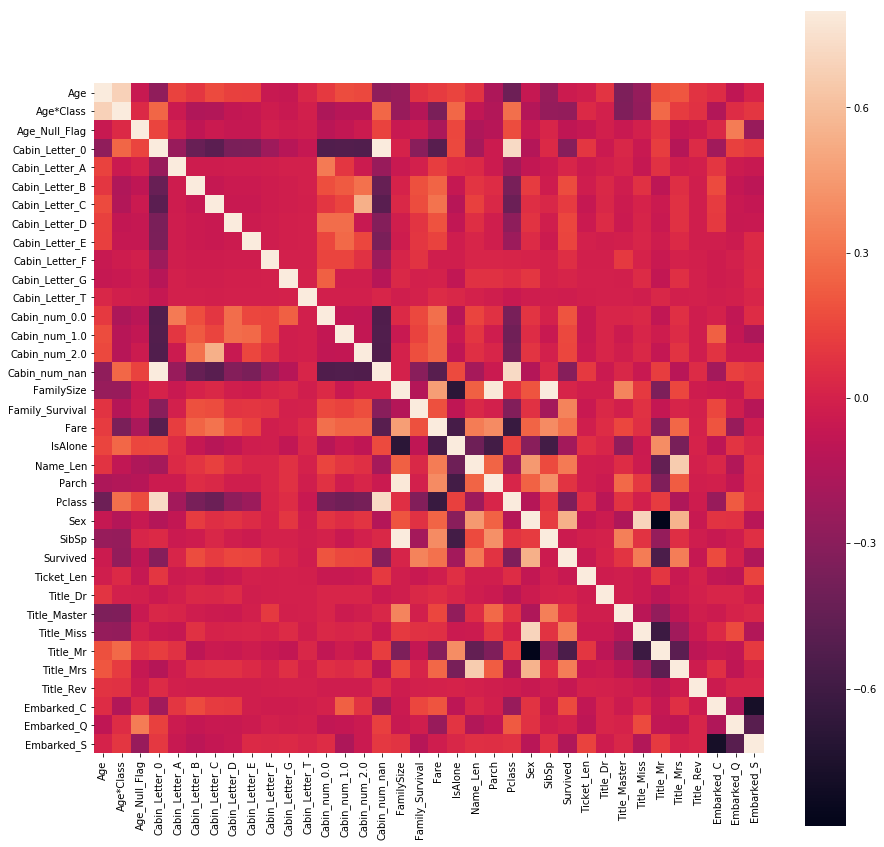

In [79]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, vmax=.8, square=True,)

### select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

In [80]:
# keep FamilySize only

train_df = train_df.drop(['Parch', 'SibSp', 'IsAlone'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'IsAlone'], axis=1)
combine = [train_df, test_df]

- Age*Class is duplicated. Age and Pclass is enough, i think

- Name_Len looks no meaning

In [81]:
train_df = train_df.drop(['Name_Len'], axis=1)
test_df = test_df.drop(['Name_Len'], axis=1)
combine = [train_df, test_df]

- Ticket_Len looks no meaning

In [82]:
train_df = train_df.drop(['Ticket_Len'], axis=1)
test_df = test_df.drop(['Ticket_Len'], axis=1)
combine = [train_df, test_df]

- Cabin_Num looks no meaning. Cabin null feature is included in Cabinb_Letter value.

In [83]:
train_df = train_df.drop(['Cabin_num_0.0', 'Cabin_num_1.0',
                          'Cabin_num_2.0', 'Cabin_num_nan'], axis=1)
test_df = test_df.drop(['Cabin_num_0.0', 'Cabin_num_1.0',
                        'Cabin_num_2.0', 'Cabin_num_nan'], axis=1)

combine = [train_df, test_df]

- Cabin_Letter looks not so effective

In [84]:
train_df = train_df.drop(['Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B',
                          'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
                          'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T'],
                         axis=1)
test_df = test_df.drop(['Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B',
                          'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
                          'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T'],
                         axis=1)

combine = [train_df, test_df]

- Title looks not so effective

In [85]:
train_df = train_df.drop(['Title_Dr', 'Title_Master', 'Title_Miss', 
                         'Title_Mr', 'Title_Mrs', 'Title_Rev'],
                         axis=1)
test_df = test_df.drop(['Title_Dr', 'Title_Master', 'Title_Miss', 
                         'Title_Mr', 'Title_Mrs', 'Title_Rev'],
                         axis=1)
combine = [train_df, test_df]

**reduce so many features except very important features**

In [86]:
train_df = train_df.drop(['Embarked_C', 'Embarked_Q',
                          'Embarked_S'], axis=1)
test_df = test_df.drop(['Embarked_C', 'Embarked_Q',
                          'Embarked_S'], axis=1)


train_df = train_df.drop(['Age_Null_Flag'], axis=1)
test_df = test_df.drop(['Age_Null_Flag'], axis=1)

combine = [train_df, test_df]

In [87]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns)

(891, 8) (418, 8)
Index(['Age', 'Age*Class', 'FamilySize', 'Family_Survival', 'Fare', 'Pclass',
       'Sex', 'Survived'],
      dtype='object') Index(['Age', 'Age*Class', 'FamilySize', 'Family_Survival', 'Fare',
       'PassengerId', 'Pclass', 'Sex'],
      dtype='object')


In [88]:
train_df.head()

,Age,Age*Class,FamilySize,Family_Survival,Fare,Pclass,Sex,Survived
0,1.0,3.0,2,0.5,0,3,0,0.0
1,2.0,2.0,2,0.5,3,1,1,1.0
2,1.0,3.0,1,0.5,1,3,1,1.0
3,2.0,2.0,2,0.0,3,1,1,1.0
4,2.0,6.0,1,0.5,1,3,0,0.0


In [89]:
test_df.head()

,Age,Age*Class,FamilySize,Family_Survival,Fare,PassengerId,Pclass,Sex
0,2.0,6.0,1,0.5,0,892,3,0
1,2.0,6.0,2,0.5,0,893,3,1
2,3.0,6.0,1,0.5,1,894,2,0
3,1.0,3.0,1,0.5,1,895,3,0
4,1.0,3.0,3,1.0,1,896,3,1


In [90]:
corrmat = train_df.corr()
corrmat

,Age,Age*Class,FamilySize,Family_Survival,Fare,Pclass,Sex,Survived
Age,1.000000,0.684130,-0.247971,0.079777,0.110882,-0.412104,-0.063598,-0.035985
Age*Class,0.684130,1.000000,-0.244061,-0.127638,-0.361193,0.290595,-0.140073,-0.260449
FamilySize,-0.247971,-0.244061,1.000000,-0.133986,0.465815,0.065997,0.200988,0.016639
Family_Survival,0.079777,-0.127638,-0.133986,1.000000,0.188162,-0.325234,0.071347,0.365530
Fare,0.110882,-0.361193,0.465815,0.188162,1.000000,-0.628459,0.248940,0.295875
Pclass,-0.412104,0.290595,0.065997,-0.325234,-0.628459,1.000000,-0.131900,-0.338481
Sex,-0.063598,-0.140073,0.200988,0.071347,0.248940,-0.131900,1.000000,0.543351
Survived,-0.035985,-0.260449,0.016639,0.365530,0.295875,-0.338481,0.543351,1.000000


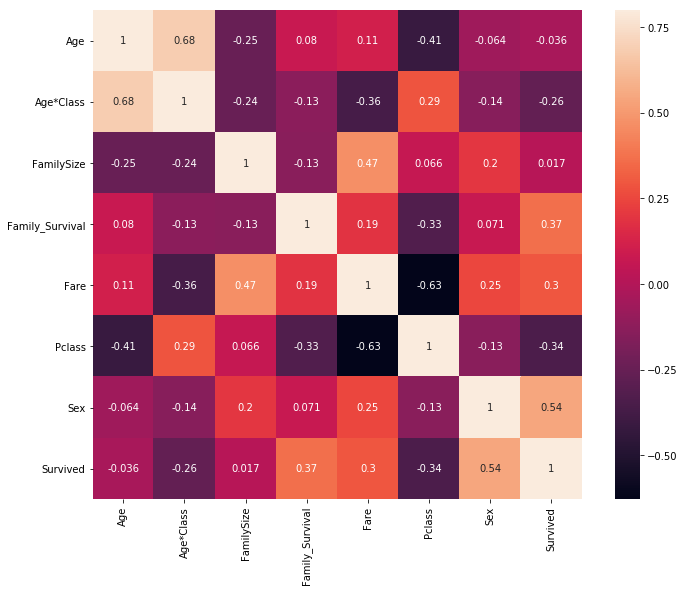

In [91]:
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

----

# model and estimate

In [92]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)
# 33, 

train/test data shape (596, 7) (295, 7)


----

## SVC

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 614 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    5.8s finished


best parameters: {'svc__C': 500, 'svc__gamma': 0.008}
Mean cross-validated score of the best_estimator:  0.8338926174496645
test:  0.8542372881355932
confusion matrix:  [[164  11]
 [ 32  88]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.833893(std:0.038351)|[500, 0.008]
2|0.832215(std:0.040640)|[1000, 0.005]
3|0.830537(std:0.039462)|[500, 0.01]
3|0.830537(std:0.040520)|[1000, 0.008]
5|0.827181(std:0.047538)|[500, 0.005]
6|0.825503(std:0.040923)|[30, 0.04]
6|0.825503(std:0.044298)|[90, 0.04]
6|0.825503(std:0.047240)|[100, 0.01]
9|0.823826(std:0.036672)|[10, 0.05]
9|0.823826(std:0.033847)|[50, 0.03]
9|0.823826(std:0.045441)|[50, 0.05]
9|0.823826(std:0.049399)|[90, 0.01]
9|0.823826(std:0.045989)|[100, 0.04]


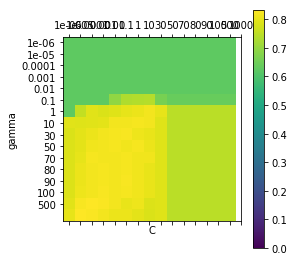

In [125]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, minmax scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 614 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    5.0s finished


best parameters: {'svc__C': 1000, 'svc__gamma': 0.03}
Mean cross-validated score of the best_estimator:  0.8338926174496645
test:  0.864406779661017
confusion matrix:  [[167   8]
 [ 32  88]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.833893(std:0.044706)|[1000, 0.03]
2|0.830537(std:0.042098)|[1000, 0.04]
3|0.828859(std:0.028114)|[80, 1]
3|0.828859(std:0.036739)|[500, 0.04]
3|0.828859(std:0.036739)|[500, 0.05]
6|0.827181(std:0.039988)|[10, 0.1]
6|0.827181(std:0.039988)|[50, 0.04]
6|0.827181(std:0.039988)|[50, 0.05]
6|0.827181(std:0.039988)|[70, 0.04]
6|0.827181(std:0.028045)|[70, 1]
6|0.827181(std:0.039988)|[90, 0.03]
6|0.827181(std:0.036038)|[90, 0.1]
6|0.827181(std:0.025574)|[90, 1]
6|0.827181(std:0.039988)|[100, 0.03]
6|0.827181(std:0.036038)|[100, 0.1]
6|0.827181(std:0.039988)|[1000, 0.01]


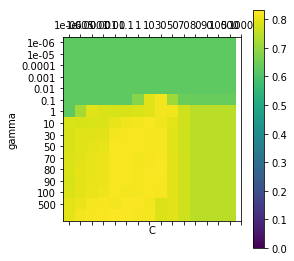

In [126]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(MinMaxScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, robust scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 810 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    6.5s finished


best parameters: {'svc__C': 500, 'svc__gamma': 0.008}
Mean cross-validated score of the best_estimator:  0.8322147651006712
test:  0.8610169491525423
confusion matrix:  [[164  11]
 [ 30  90]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.832215(std:0.035498)|[500, 0.008]
1|0.832215(std:0.040640)|[1000, 0.005]
1|0.832215(std:0.040640)|[1000, 0.008]
4|0.830537(std:0.040790)|[500, 0.01]
5|0.827181(std:0.042295)|[10, 0.05]
5|0.827181(std:0.033350)|[50, 0.03]
7|0.825503(std:0.041586)|[70, 0.04]
7|0.825503(std:0.044298)|[80, 0.04]
7|0.825503(std:0.044298)|[90, 0.04]
7|0.825503(std:0.047240)|[500, 0.005]


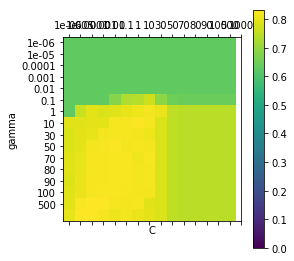

In [127]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(RobustScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, StandardScaler scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 614 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    5.7s finished


best parameters: {'svc__C': 10, 'svc__gamma': 0.03}
Mean cross-validated score of the best_estimator:  0.8305369127516778
test:  0.8745762711864407
confusion matrix:  [[167   8]
 [ 29  91]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.830537(std:0.036516)|[10, 0.03]
1|0.830537(std:0.036452)|[30, 0.01]
1|0.830537(std:0.036452)|[50, 0.008]
1|0.830537(std:0.042918)|[50, 0.01]
1|0.830537(std:0.043588)|[50, 0.04]
1|0.830537(std:0.042918)|[70, 0.008]
1|0.830537(std:0.042918)|[80, 0.008]
8|0.828859(std:0.033687)|[1, 0.05]
8|0.828859(std:0.036948)|[70, 0.04]
8|0.828859(std:0.042721)|[90, 0.008]
8|0.828859(std:0.039247)|[90, 0.01]
8|0.828859(std:0.036543)|[100, 0.005]
8|0.828859(std:0.039247)|[1000, 0.005]


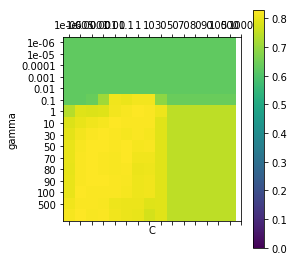

In [128]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(StandardScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

In [142]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(StandardScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

grid_search.fit(X_train_df, y_train_df)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
report2(grid_search.cv_results_, n_top=10)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = grid_search.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_svcStandardScaler.csv', index=False)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    3.0s


best parameters: {'svc__C': 30, 'svc__gamma': 0.03}
Mean cross-validated score of the best_estimator:  0.8484848484848485
Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.848485(std:0.018602)|[30, 0.03]
2|0.847363(std:0.018459)|[10, 0.05]
2|0.847363(std:0.017302)|[500, 0.01]
4|0.846240(std:0.017075)|[1000, 0.008]
5|0.845118(std:0.021094)|[1, 0.04]
5|0.845118(std:0.021483)|[1, 0.05]
5|0.845118(std:0.020535)|[1, 0.1]
5|0.845118(std:0.020535)|[10, 0.04]
5|0.845118(std:0.015887)|[30, 0.04]
5|0.845118(std:0.015887)|[50, 0.03]
5|0.845118(std:0.015887)|[70, 0.03]
5|0.845118(std:0.012741)|[80, 0.03]
5|0.845118(std:0.012741)|[90, 0.03]
5|0.845118(std:0.013690)|[100, 0.03]
5|0.845118(std:0.015366)|[1000, 0.01]


[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:   10.8s finished


----

## KNeighborsClassifier

In [129]:
# no cale
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 9}
Mean cross-validated score of the best_estimator:  0.7969798657718121
test:  0.8067796610169492
confusion matrix:  [[145  30]
 [ 27  93]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.796980(std:0.058592)|[9]
1|0.796980(std:0.034392)|[15]
3|0.790268(std:0.040655)|[7]
4|0.788591(std:0.038446)|[8]
5|0.781879(std:0.024371)|[4]
6|0.780201(std:0.039844)|[5]
6|0.780201(std:0.051858)|[10]
8|0.778523(std:0.037331)|[6]
9|0.761745(std:0.043072)|[20]
10|0.758389(std:0.050018)|[3]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.2s finished


### minmax scaler

In [130]:
# minmax scaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 5}
Mean cross-validated score of the best_estimator:  0.825503355704698
test:  0.8203389830508474
confusion matrix:  [[152  23]
 [ 30  90]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.825503(std:0.032289)|[5]
2|0.822148(std:0.022472)|[4]
3|0.818792(std:0.035580)|[6]
4|0.812081(std:0.015415)|[15]
5|0.810403(std:0.029501)|[9]
6|0.807047(std:0.038369)|[7]
6|0.807047(std:0.024705)|[8]
6|0.807047(std:0.021003)|[10]
9|0.800336(std:0.027111)|[20]
10|0.778523(std:0.038448)|[3]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.2s finished


### robust scaler

In [131]:
# robust scaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(RobustScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 15}
Mean cross-validated score of the best_estimator:  0.8003355704697986
test:  0.8305084745762712
confusion matrix:  [[156  19]
 [ 31  89]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.800336(std:0.047347)|[15]
2|0.791946(std:0.036246)|[7]
3|0.786913(std:0.034982)|[8]
3|0.786913(std:0.048017)|[10]
5|0.781879(std:0.025067)|[4]
5|0.781879(std:0.034439)|[5]
5|0.781879(std:0.033459)|[6]
8|0.780201(std:0.049112)|[9]
9|0.770134(std:0.060153)|[2]
10|0.763423(std:0.043949)|[20]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.2s finished


### StandardScaler

In [132]:
# StandardScaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 20}
Mean cross-validated score of the best_estimator:  0.825503355704698
test:  0.8576271186440678
confusion matrix:  [[167   8]
 [ 34  86]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.825503(std:0.047862)|[20]
2|0.817114(std:0.047809)|[15]
3|0.810403(std:0.038511)|[4]
3|0.810403(std:0.031741)|[10]
5|0.805369(std:0.026794)|[5]
5|0.805369(std:0.028227)|[8]
7|0.802013(std:0.023978)|[6]
8|0.798658(std:0.032234)|[7]
8|0.798658(std:0.040124)|[9]
10|0.796980(std:0.051915)|[3]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.2s finished


----

# random forest result for compare

**normal**

In [133]:
"""
# too wide
param_grid = {'randomforestclassifier__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25 None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2', None],
             'randomforestclassifier__min_samples_leaf': [1,2,3,4,5],
             "randomforestclassifier__min_samples_split" : [2,3,4,5,6,7],
             'randomforestclassifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 100],
              }
"""
# narrow down
param_grid = {'randomforestclassifier__max_depth':[5,6,7,8,9],
             'randomforestclassifier__max_features': [1,'sqrt','log2'],
#             'randomforestclassifier__min_samples_leaf': [1,2,3,5],
             "randomforestclassifier__min_samples_split" : [2,3,4,5,6,7,8,9],
             'randomforestclassifier__n_estimators': [10,20,30,40,50,60,100,200,300,500,700],
              }
pipe = make_pipeline(
#    SelectFromModel(RandomForestClassifier(n_estimators=100), threshold="median"), 
#    SelectFromModel(RandomForestClassifier(n_estimators=500), threshold="median"), 
#    SelectFromModel(
#        RandomForestClassifier(
#            max_depth=6, max_features="sqrt", 
#            min_samples_split=4,n_estimators=40)
#    ),
#    SelectPercentile(percentile=70),
    RandomForestClassifier()
)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=6, verbose=1)
#grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 1320 candidates, totalling 6600 fits


[Parallel(n_jobs=6)]: Done 316 tasks      | elapsed:   12.4s
[Parallel(n_jobs=6)]: Done 598 tasks      | elapsed:   25.0s
[Parallel(n_jobs=6)]: Done 1011 tasks      | elapsed:   42.5s
[Parallel(n_jobs=6)]: Done 1642 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2542 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3507 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4632 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 5915 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 6589 out of 6600 | elapsed:  4.9min remaining:    0.5s


best parameters: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 1, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 40}
Mean cross-validated score of the best_estimator:  0.8389261744966443
test:  0.8372881355932204
confusion matrix:  [[169   6]
 [ 42  78]]

Rank|Score(std)|Params ['randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__n_estimators']
1|0.838926(std:0.048392)|[5, 1, 6, 40]
1|0.838926(std:0.043068)|[7, 'log2', 4, 10]
3|0.837248(std:0.027141)|[6, 'log2', 6, 50]
3|0.837248(std:0.031437)|[7, 'sqrt', 6, 700]
3|0.837248(std:0.028431)|[7, 'log2', 4, 50]
3|0.837248(std:0.036504)|[7, 'log2', 9, 20]
3|0.837248(std:0.033632)|[8, 1, 5, 30]
3|0.837248(std:0.037093)|[8, 'sqrt', 6, 50]
3|0.837248(std:0.031437)|[8, 'sqrt', 8, 40]
3|0.837248(std:0.035045)|[9, 'sqrt', 8, 10]


[Parallel(n_jobs=6)]: Done 6600 out of 6600 | elapsed:  4.9min finished


In [134]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
6,Sex,0.380396
3,Family_Survival,0.185836
5,Pclass,0.117579
1,Age*Class,0.106884
2,FamilySize,0.083877
4,Fare,0.066629
0,Age,0.058799


In [135]:
#pipe.fit(X_train_df, y_train_df)
grid_search.fit(X_train_df, y_train_df)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
report2(grid_search.cv_results_, n_top=10)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = grid_search.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_randomforest.csv', index=False)

Fitting 5 folds for each of 1320 candidates, totalling 6600 fits


[Parallel(n_jobs=6)]: Done 301 tasks      | elapsed:   13.2s
[Parallel(n_jobs=6)]: Done 562 tasks      | elapsed:   25.8s
[Parallel(n_jobs=6)]: Done 935 tasks      | elapsed:   43.4s
[Parallel(n_jobs=6)]: Done 1533 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2280 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3093 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 3993 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5195 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 6378 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 6589 out of 6600 | elapsed:  5.2min remaining:    0.5s


best parameters: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__n_estimators': 20}
Mean cross-validated score of the best_estimator:  0.8451178451178452
Rank|Score(std)|Params ['randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__n_estimators']
1|0.845118(std:0.016380)|[5, 'sqrt', 4, 20]
2|0.843996(std:0.010699)|[6, 1, 5, 10]
2|0.843996(std:0.010423)|[7, 'sqrt', 4, 60]
2|0.843996(std:0.023070)|[9, 'log2', 9, 30]
5|0.842873(std:0.023210)|[6, 'sqrt', 6, 10]
5|0.842873(std:0.015031)|[6, 'log2', 3, 30]
5|0.842873(std:0.011367)|[7, 'log2', 7, 30]
5|0.842873(std:0.013722)|[8, 'log2', 7, 40]
9|0.841751(std:0.012644)|[5, 'sqrt', 4, 30]
9|0.841751(std:0.014132)|[5, 'log2', 2, 50]
9|0.841751(std:0.014132)|[6, 'sqrt', 3, 700]
9|0.841751(std:0.015288)|[6, 'sqrt', 4, 30]
9|0.841751(std:0.01413

[Parallel(n_jobs=6)]: Done 6600 out of 6600 | elapsed:  5.2min finished


**just trial of PolynomialFeatures(degree=2)**

In [136]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
6,Sex,0.414616
3,Family_Survival,0.211309
5,Pclass,0.118390
1,Age*Class,0.103607
2,FamilySize,0.069360
0,Age,0.045865
4,Fare,0.036852


----

## XGBoost

In [98]:
param_grid = {
    'max_depth': [0,1,2,3,4,5,6,7,8,9,10],
    'learning_rate': [0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2],
    'n_estimators': [7, 10, 50, 100, 200, 300, 400, 500],
    'gamma':[0, 0.1, 0.2],
    'min_child_weight':[0.8,0.9, 1],
    'subsample': [0.5, 0.7, 0.95],
    'colsample_bytree': [1.0],
}

import warnings
warnings.simplefilter("ignore")
    
grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)


print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)


Fitting 5 folds for each of 16632 candidates, totalling 83160 fits


[Parallel(n_jobs=6)]: Done 1300 tasks      | elapsed:    7.1s
[Parallel(n_jobs=6)]: Done 3072 tasks      | elapsed:   26.0s
[Parallel(n_jobs=6)]: Done 5072 tasks      | elapsed:   43.0s
[Parallel(n_jobs=6)]: Done 7872 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 11472 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 15872 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 21072 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 27072 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 33872 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 41472 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 49872 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 59072 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 69072 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 79872 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 83160 out of 83160 | elapsed: 13.6min finished


best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 0.8, 'n_estimators': 400, 'subsample': 0.7}
Mean cross-validated score of the best_estimator:  0.8406040268456376
test:  0.8508474576271187
confusion matrix:  [[163  12]
 [ 32  88]]

Rank|Score(std)|Params ['colsample_bytree', 'gamma', 'learning_rate', 'max_depth', 'min_child_weight', 'n_estimators', 'subsample']
1|0.840604(std:0.036467)|[1.0, 0.1, 0.02, 4, 0.8, 400, 0.7]
2|0.838926(std:0.032131)|[1.0, 0, 0.02, 4, 0.9, 300, 0.7]
2|0.838926(std:0.032131)|[1.0, 0, 0.02, 4, 1, 300, 0.7]
2|0.838926(std:0.031576)|[1.0, 0, 0.1, 4, 0.9, 100, 0.7]
2|0.838926(std:0.032131)|[1.0, 0.1, 0.02, 4, 0.8, 300, 0.7]
2|0.838926(std:0.041976)|[1.0, 0.1, 0.02, 4, 0.8, 300, 0.95]
2|0.838926(std:0.032131)|[1.0, 0.1, 0.02, 4, 0.9, 300, 0.7]
2|0.838926(std:0.035113)|[1.0, 0.1, 0.02, 4, 0.9, 400, 0.7]
2|0.838926(std:0.032131)|[1.0, 0.1, 0.02, 4, 1, 300, 0.7]
2|0.838926(std:0.035113)|[1.0, 0.1, 0.0

----

## LightGBM

In [97]:
param_grid = {
#    'silent': True,
    'learning_rate': [0.005],
    'n_estimators': [7, 10, 50, 100, 200, 300, 400, 500],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
#    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
}


import warnings
warnings.simplefilter("ignore")
    
grid_search = GridSearchCV(lgb.LGBMClassifier(), param_grid, cv=5, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)


print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=1)]: Done 5760 out of 5760 | elapsed:  5.6min finished


best parameters: {'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.005, 'n_estimators': 200, 'num_leaves': 6, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
Mean cross-validated score of the best_estimator:  0.825503355705
test:  0.833898305085
confusion matrix:  [[169   6]
 [ 43  77]]

Rank|Score(std)|Params ['boosting_type', 'colsample_bytree', 'learning_rate', 'n_estimators', 'num_leaves', 'objective', 'reg_alpha', 'reg_lambda', 'subsample']
1|0.825503(std:0.040196)|['gbdt', 0.64, 0.005, 200, 6, 'binary', 1, 1, 0.7]
1|0.825503(std:0.040196)|['gbdt', 0.64, 0.005, 200, 6, 'binary', 1, 1.4, 0.7]
1|0.825503(std:0.040196)|['gbdt', 0.64, 0.005, 200, 6, 'binary', 1.2, 1, 0.7]
1|0.825503(std:0.040196)|['gbdt', 0.64, 0.005, 200, 8, 'binary', 1, 1, 0.7]
1|0.825503(std:0.040196)|['gbdt', 0.64, 0.005, 200, 12, 'binary', 1, 1, 0.7]
1|0.825503(std:0.040196)|['gbdt', 0.64, 0.005, 200, 16, 'binary', 1, 1, 0.7]
1|0.825503(std:0.047561)|['gbdt', 0.64, 0

----

## AdaBoostClassifier

In [94]:
"""
AdaBoostClassifier(base_estimator=None, 
                   n_estimators=50,
                   learning_rate=1.0, 
                   algorithm='SAMME.R',
                   random_state=None)
"""


param_grid = {'learning_rate': [0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2],
              'n_estimators': [7, 10, 50, 100, 200, 300, 400, 500],
              'algorithm':["SAMME", "SAMME.R"]
              }

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)



Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=6)]: Done 352 tasks      | elapsed:   16.7s
[Parallel(n_jobs=6)]: Done 538 tasks      | elapsed:   25.7s
[Parallel(n_jobs=6)]: Done 560 out of 560 | elapsed:   27.8s finished


best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.05, 'n_estimators': 500}
Mean cross-validated score of the best_estimator:  0.8187919463087249
test:  0.8542372881355932
confusion matrix:  [[165  10]
 [ 33  87]]

Rank|Score(std)|Params ['algorithm', 'learning_rate', 'n_estimators']
1|0.818792(std:0.038769)|['SAMME', 0.05, 500]
1|0.818792(std:0.038769)|['SAMME.R', 0.01, 500]
1|0.818792(std:0.045612)|['SAMME.R', 0.02, 300]
4|0.815436(std:0.048679)|['SAMME.R', 0.05, 300]
5|0.813758(std:0.037344)|['SAMME', 0.2, 100]
6|0.812081(std:0.041626)|['SAMME', 0.05, 400]
6|0.812081(std:0.038911)|['SAMME', 0.2, 200]
6|0.812081(std:0.052225)|['SAMME.R', 0.02, 500]
6|0.812081(std:0.048794)|['SAMME.R', 0.1, 50]
10|0.810403(std:0.038751)|['SAMME', 0.05, 300]
10|0.810403(std:0.046744)|['SAMME.R', 0.01, 400]
10|0.810403(std:0.046744)|['SAMME.R', 0.02, 200]
10|0.810403(std:0.049715)|['SAMME.R', 0.05, 200]
10|0.810403(std:0.049715)|['SAMME.R', 0.1, 100]


----

## GradientBoostingClassifier

In [94]:
"""
# too wide
param_grid = {'learning_rate': [0.001, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2],
              'max_depth':[1,2,3,4,5,6,7,8],
              'max_features': [None, 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6],
              'min_samples_split':[2, 3, 4, 5, 6],
              'n_estimators': [3, 5, 7, 10, 50, 100, 200, 300, 400, 500],
              }
"""

# narrow in specific region
param_grid = {'learning_rate': [0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2],
              'max_depth':[3,4,5,6,7],
              'max_features': [None, 'sqrt', 'log2'],
#              'min_samples_leaf': [1, 2, 3, 4, 5],
              'min_samples_split':[2, 3, 4, 5, 6],
              'n_estimators': [7, 10, 50, 75, 100, 200, 300, 400, 500],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              }

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 32400 candidates, totalling 162000 fits


[Parallel(n_jobs=6)]: Done 700 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done 1706 tasks      | elapsed:   36.5s
[Parallel(n_jobs=6)]: Done 2809 tasks      | elapsed:   59.2s
[Parallel(n_jobs=6)]: Done 3973 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 6314 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 9169 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 12060 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 14292 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 17013 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 19435 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 24340 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 30515 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 35185 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 38912 tasks      | elapsed: 26.9min
[Parallel(n_jobs=6)]: Done 44512 tasks      | elapsed: 30.1min
[Parallel(n_jobs=6)]: Done 52629 tasks      | elapsed: 34.6min

best parameters: {'learning_rate': 0.007, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 400, 'subsample': 0.5}
Mean cross-validated score of the best_estimator:  0.8406040268456376
test:  0.8508474576271187
confusion matrix:  [[163  12]
 [ 32  88]]

Rank|Score(std)|Params ['learning_rate', 'max_depth', 'max_features', 'min_samples_split', 'n_estimators', 'subsample']
1|0.840604(std:0.032947)|[0.007, 5, 'sqrt', 6, 400, 0.5]
1|0.840604(std:0.036225)|[0.05, 3, 'log2', 4, 50, 0.6]
3|0.838926(std:0.039127)|[0.007, 4, None, 6, 400, 0.6]
3|0.838926(std:0.030419)|[0.007, 5, 'sqrt', 4, 500, 0.6]
3|0.838926(std:0.029322)|[0.01, 4, None, 5, 500, 0.8]
3|0.838926(std:0.027436)|[0.01, 5, 'sqrt', 6, 300, 0.7]
3|0.838926(std:0.041946)|[0.02, 3, None, 3, 200, 0.8]
3|0.838926(std:0.039127)|[0.02, 3, None, 5, 200, 0.5]
3|0.838926(std:0.032131)|[0.02, 4, None, 4, 200, 0.8]
3|0.838926(std:0.039127)|[0.02, 4, None, 5, 200, 0.6]
3|0.838926(std:0.039159)|[0.05, 3, None, 5, 50

In [95]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
6,Sex,0.287247
3,Family_Survival,0.154264
2,FamilySize,0.134666
1,Age*Class,0.119561
5,Pclass,0.107472
4,Fare,0.103863
0,Age,0.092927


**for submit, make model by best par and fit to all train data**

In [139]:
#pipe.fit(X_train_df, y_train_df)
grid_search.fit(X_train_df, y_train_df)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
report2(grid_search.cv_results_, n_top=10)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = grid_search.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_gradientboosting.csv', index=False)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


[Parallel(n_jobs=6)]: Done 354 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done 668 tasks      | elapsed:   15.3s
[Parallel(n_jobs=6)]: Done 1168 tasks      | elapsed:   30.9s
[Parallel(n_jobs=6)]: Done 1868 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2326 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 2876 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 3995 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5190 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 6040 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 7905 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 8956 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 11039 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 12516 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 14546 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 16928 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 18898 tasks      | elapsed: 16.0min
[Para

best parameters: {'learning_rate': 0.005, 'max_depth': 3, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 200}
Mean cross-validated score of the best_estimator:  0.8473625140291807
Rank|Score(std)|Params ['learning_rate', 'max_depth', 'max_features', 'min_samples_split', 'n_estimators']
1|0.847363(std:0.018459)|[0.005, 3, None, 2, 200]
1|0.847363(std:0.018459)|[0.005, 3, None, 3, 200]
1|0.847363(std:0.018459)|[0.005, 3, None, 4, 200]
1|0.847363(std:0.018459)|[0.005, 3, None, 5, 200]
1|0.847363(std:0.018459)|[0.005, 3, None, 6, 200]
1|0.847363(std:0.018696)|[0.007, 3, None, 6, 500]
1|0.847363(std:0.018459)|[0.01, 3, None, 2, 100]
1|0.847363(std:0.018696)|[0.01, 3, None, 2, 300]
1|0.847363(std:0.018459)|[0.01, 3, None, 3, 100]
1|0.847363(std:0.018696)|[0.01, 3, None, 3, 300]
1|0.847363(std:0.018459)|[0.01, 3, None, 4, 100]
1|0.847363(std:0.018459)|[0.01, 3, None, 5, 100]
1|0.847363(std:0.018459)|[0.01, 3, None, 6, 100]
1|0.847363(std:0.018459)|[0.02, 3, None, 2, 50]
1|0.847

In [140]:
pd.concat((pd.DataFrame(X_train_df.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
6,Sex,0.564469
3,Family_Survival,0.195352
5,Pclass,0.146711
1,Age*Class,0.052570
2,FamilySize,0.030484
0,Age,0.009835
4,Fare,0.000579


**just trial of PolynomialFeatures**

In [141]:
import warnings
warnings.simplefilter("ignore")

### search hyper parameter by sklearn-deap


In [103]:
# !!!!! without disabling warning, too much output and freezed almost!!!!
# neet to watch output everytime

param_distributions = {
    #'learning_rate': sp.stats.uniform(0.001, 0.5),
#    'learning_rate': [0.001, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2],
    'learning_rate': np.arange(0.001, 0.8, 0.001),
#    'max_depth':[1,2,3,4,5,6,7,8,9,10],
    'max_depth':range(1,13),
    'max_features': [None, 'sqrt', 'log2'],
#    'min_samples_leaf': [1, 2, 3, 4, 5, 6,7,8],
    'min_samples_leaf': range(1,10),
#    'min_samples_split':[2, 3, 4, 5, 6,7,8,9],
    'min_samples_split': range(2,12),
#    'n_estimators': [3, 5, 7, 10, 50, 100, 200, 300, 400, 500],
    'n_estimators': range(1,1000),
}

from evolutionary_search import EvolutionaryAlgorithmSearchCV

ea_search = EvolutionaryAlgorithmSearchCV(estimator=GradientBoostingClassifier(),
                                   params=param_distributions,
                                   scoring="accuracy",
#                                   cv=StratifiedKFold(n_splits=4),
                                   cv=5,
                                   verbose=1,
                                   population_size=100,
                                   gene_mutation_prob=0.90,
                                   gene_crossover_prob=0.3,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=6)
ea_search.fit(X_train, y_train)


print("best parameters:", ea_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", ea_search.best_score_)
print("test: ", ea_search.best_estimator_.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, ea_search.best_estimator_.predict(X_test)))
print("")
#report2(ea_search.cv_results_, n_top=10)

Types [2, 1, 1, 1, 1, 1] and maxint [798, 11, 2, 8, 9, 998] detected
--- Evolve in 2586171240 possible combinations ---
gen	nevals	avg     	min     	max     	std       
0  	100   	0.798372	0.776846	0.818792	0.00850608
1  	68    	0.804346	0.781879	0.822148	0.00898519
2  	59    	0.808104	0.780201	0.827181	0.00940692
3  	65    	0.807601	0.716443	0.825503	0.016076  
4  	62    	0.81396 	0.783557	0.83557 	0.0105805 
5  	70    	0.807617	0.627517	0.837248	0.030195  
6  	66    	0.812668	0.627517	0.83557 	0.0312192 
7  	61    	0.81396 	0.627517	0.837248	0.0356576 
8  	71    	0.816829	0.627517	0.838926	0.0293582 
9  	58    	0.822181	0.682886	0.838926	0.0220585 
10 	53    	0.823272	0.627517	0.838926	0.0253473 
Best individual is: {'learning_rate': 0.004, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 988}
with fitness: 0.8389261744966443
best parameters: {'learning_rate': 0.004, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 9, '

# TPOT

In [95]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(
    generations=100, 
    population_size=100, 
    verbosity=2,
    early_stop=10,
    n_jobs=6,
#    mutation_rate=0.5,
#    crossover_rate=0.5,
#    config_dict='TPOT MDR',
)

# mutation_rate: default 0.9, crossover_rate: default 0.1
# mutation_rate=0.5, crossover_rate=0.5)
# , config_dict='TPOT MDR' should be better, but became fast and low score...

tpot.fit(X_train, y_train)

print("test", tpot.score(X_test, y_test))

tpot.export('tpot_titanic_'+ time.strftime("%Y-%m-%d-%H-%M-%S") + '.py')

Optimization Progress:   2%|▏         | 200/10100 [00:26<40:02,  4.12pipeline/s]

Generation 1 - Current best internal CV score: 0.8355986801500261


Optimization Progress:   3%|▎         | 300/10100 [00:44<44:13,  3.69pipeline/s]

Generation 2 - Current best internal CV score: 0.8372651094336041


Optimization Progress:   4%|▍         | 400/10100 [01:26<1:42:58,  1.57pipeline/s]

Generation 3 - Current best internal CV score: 0.8372651094336041


Optimization Progress:   5%|▍         | 500/10100 [01:53<1:09:07,  2.31pipeline/s]

Generation 4 - Current best internal CV score: 0.8439597873047525


Optimization Progress:   6%|▌         | 600/10100 [02:23<2:34:00,  1.03pipeline/s]

Generation 5 - Current best internal CV score: 0.8440302900821346


Optimization Progress:   7%|▋         | 700/10100 [02:43<1:30:50,  1.72pipeline/s]

Generation 6 - Current best internal CV score: 0.8440302900821346


Optimization Progress:   8%|▊         | 800/10100 [03:12<2:06:07,  1.23pipeline/s]

Generation 7 - Current best internal CV score: 0.8440302900821346


Optimization Progress:   9%|▉         | 900/10100 [03:34<1:41:42,  1.51pipeline/s]

Generation 8 - Current best internal CV score: 0.8440302900821346


Optimization Progress:  10%|▉         | 1000/10100 [03:55<1:09:22,  2.19pipeline/s]

Generation 9 - Current best internal CV score: 0.8440302900821346


Optimization Progress:  11%|█         | 1100/10100 [04:17<43:37,  3.44pipeline/s]

Generation 10 - Current best internal CV score: 0.8440302900821346


Optimization Progress:  12%|█▏        | 1200/10100 [04:31<41:30,  3.57pipeline/s]

Generation 11 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  13%|█▎        | 1300/10100 [04:56<46:26,  3.16pipeline/s]

Generation 12 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  14%|█▍        | 1400/10100 [05:20<42:38,  3.40pipeline/s]

Generation 13 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  15%|█▍        | 1500/10100 [05:41<1:00:37,  2.36pipeline/s]

Generation 14 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  16%|█▌        | 1600/10100 [05:54<38:15,  3.70pipeline/s]

Generation 15 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  17%|█▋        | 1700/10100 [06:15<32:29,  4.31pipeline/s]

Generation 16 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  18%|█▊        | 1800/10100 [06:32<32:00,  4.32pipeline/s]

Generation 17 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  19%|█▉        | 1900/10100 [06:49<41:09,  3.32pipeline/s]

Generation 18 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  20%|█▉        | 2000/10100 [07:05<27:46,  4.86pipeline/s]

Generation 19 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  21%|██        | 2100/10100 [07:17<43:13,  3.08pipeline/s]

Generation 20 - Current best internal CV score: 0.8456404595736601


Optimization Progress:  22%|██▏       | 2200/10100 [07:29<28:13,  4.66pipeline/s]

Generation 21 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  23%|██▎       | 2300/10100 [07:37<16:45,  7.76pipeline/s]

Generation 22 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  24%|██▍       | 2400/10100 [07:46<18:28,  6.94pipeline/s]

Generation 23 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  25%|██▍       | 2500/10100 [07:56<17:49,  7.11pipeline/s]

Generation 24 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  26%|██▌       | 2600/10100 [08:06<18:37,  6.71pipeline/s]

Generation 25 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  27%|██▋       | 2700/10100 [08:25<34:53,  3.53pipeline/s]

Generation 26 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  28%|██▊       | 2800/10100 [08:41<28:09,  4.32pipeline/s]

Generation 27 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  29%|██▊       | 2900/10100 [08:57<22:44,  5.28pipeline/s]

Generation 28 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  30%|██▉       | 3000/10100 [09:13<34:05,  3.47pipeline/s]

Generation 29 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  31%|███       | 3100/10100 [09:31<33:46,  3.45pipeline/s]

Generation 30 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  32%|███▏      | 3200/10100 [09:44<22:32,  5.10pipeline/s]

Generation 31 - Current best internal CV score: 0.8456969567488013


Optimization Progress:  33%|███▎      | 3300/10100 [09:59<26:33,  4.27pipeline/s]

Generation 32 - Current best internal CV score: 0.8456969567488013


Generation 33 - Current best internal CV score: 0.8456969567488013

The optimized pipeline was not improved after evaluating 10 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=4, min_samples_leaf=15, min_samples_split=5), learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, nthread=1, subsample=0.35000000000000003)
test 0.8542372881355932


/home/yuki/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


True

In [101]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(
    generations=100, 
    population_size=200, 
    verbosity=2,
    early_stop=10,
    n_jobs=6,
#    mutation_rate=0.5,
#    crossover_rate=0.5,
    config_dict='TPOT MDR',
)

# mutation_rate: default 0.9, crossover_rate: default 0.1
# mutation_rate=0.5, crossover_rate=0.5)
# , config_dict='TPOT MDR' should be better, but became fast and low score...

tpot.fit(X_train, y_train)

print("test", tpot.score(X_test, y_test))

tpot.export('tpot_titanic_'+ time.strftime("%Y-%m-%d-%H-%M-%S") + '.py')

Optimization Progress:   2%|▏         | 400/20200 [00:09<05:56, 55.54pipeline/s]

Generation 1 - Current best internal CV score: 0.8154721549636804


Optimization Progress:   3%|▎         | 600/20200 [00:18<06:10, 52.92pipeline/s]

Generation 2 - Current best internal CV score: 0.8154721549636804


Optimization Progress:   4%|▍         | 800/20200 [00:26<07:26, 43.43pipeline/s]

Generation 3 - Current best internal CV score: 0.8154721549636804


Optimization Progress:   5%|▍         | 1000/20200 [00:33<08:21, 38.32pipeline/s]

Generation 4 - Current best internal CV score: 0.8154721549636804


Optimization Progress:   6%|▌         | 1200/20200 [00:41<06:20, 49.96pipeline/s]

Generation 5 - Current best internal CV score: 0.8154721549636804


Optimization Progress:   7%|▋         | 1400/20200 [00:49<07:21, 42.58pipeline/s]

Generation 6 - Current best internal CV score: 0.8154721549636804


Optimization Progress:   8%|▊         | 1600/20200 [00:56<07:45, 39.97pipeline/s]

Generation 7 - Current best internal CV score: 0.817152827232588


Optimization Progress:   9%|▉         | 1800/20200 [01:04<06:11, 49.58pipeline/s]

Generation 8 - Current best internal CV score: 0.817152827232588


Optimization Progress:  10%|▉         | 2000/20200 [01:12<10:33, 28.72pipeline/s]

Generation 9 - Current best internal CV score: 0.817152827232588


Optimization Progress:  11%|█         | 2200/20200 [01:20<06:37, 45.23pipeline/s]

Generation 10 - Current best internal CV score: 0.817152827232588


Optimization Progress:  12%|█▏        | 2400/20200 [01:27<06:17, 47.10pipeline/s]

Generation 11 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  13%|█▎        | 2600/20200 [01:33<06:06, 47.99pipeline/s]

Generation 12 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  14%|█▍        | 2800/20200 [01:38<06:49, 42.46pipeline/s]

Generation 13 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  15%|█▍        | 3000/20200 [01:45<07:15, 39.49pipeline/s]

Generation 14 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  16%|█▌        | 3200/20200 [01:53<08:37, 32.87pipeline/s]

Generation 15 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  17%|█▋        | 3400/20200 [01:58<06:55, 40.48pipeline/s]

Generation 16 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  18%|█▊        | 3600/20200 [02:04<07:18, 37.88pipeline/s]

Generation 17 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  19%|█▉        | 3800/20200 [02:08<06:22, 42.85pipeline/s]

Generation 18 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  20%|█▉        | 4000/20200 [02:12<05:22, 50.21pipeline/s]

Generation 19 - Current best internal CV score: 0.8187770023263543


Optimization Progress:  21%|██        | 4200/20200 [02:17<06:05, 43.79pipeline/s]

Generation 20 - Current best internal CV score: 0.8187770023263543


Generation 21 - Current best internal CV score: 0.8187770023263543

The optimized pipeline was not improved after evaluating 10 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(CombineDFs(LogisticRegression(LogisticRegression(LogisticRegression(input_matrix, C=0.1, dual=False, penalty=l1), C=20.0, dual=False, penalty=l1), C=0.1, dual=True, penalty=l2), input_matrix), C=0.5, dual=True, penalty=l2)
test 0.8372881355932204


True

In [102]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(
    generations=100, 
    population_size=200, 
    verbosity=2,
    early_stop=10,
    n_jobs=6,
#    mutation_rate=0.5,
#    crossover_rate=0.5,
#    config_dict='TPOT MDR',
)

# mutation_rate: default 0.9, crossover_rate: default 0.1
# mutation_rate=0.5, crossover_rate=0.5)
# , config_dict='TPOT MDR' should be better, but became fast and low score...

tpot.fit(X_train, y_train)

print("test", tpot.score(X_test, y_test))

tpot.export('tpot_titanic_'+ time.strftime("%Y-%m-%d-%H-%M-%S") + '.py')

Optimization Progress:   2%|▏         | 400/20200 [00:57<40:49,  8.08pipeline/s]

Generation 1 - Current best internal CV score: 0.8389597873047524


Optimization Progress:   3%|▎         | 600/20200 [01:57<1:09:48,  4.68pipeline/s]

Generation 2 - Current best internal CV score: 0.8389597873047524


Optimization Progress:   4%|▍         | 800/20200 [03:07<1:40:17,  3.22pipeline/s]

Generation 3 - Current best internal CV score: 0.8389597873047524


Optimization Progress:   5%|▍         | 1000/20200 [04:10<1:06:41,  4.80pipeline/s]

Generation 4 - Current best internal CV score: 0.8389597873047524


Optimization Progress:   6%|▌         | 1200/20200 [05:30<3:21:12,  1.57pipeline/s]

Generation 5 - Current best internal CV score: 0.8456544651759008


Optimization Progress:   7%|▋         | 1400/20200 [06:33<1:21:12,  3.86pipeline/s]

Generation 6 - Current best internal CV score: 0.8456544651759008


Optimization Progress:   8%|▊         | 1600/20200 [07:44<1:56:14,  2.67pipeline/s]

Generation 7 - Current best internal CV score: 0.8456544651759008


Optimization Progress:   9%|▉         | 1800/20200 [08:50<1:26:56,  3.53pipeline/s]

Generation 8 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  10%|▉         | 2000/20200 [09:59<1:47:48,  2.81pipeline/s]

Generation 9 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  11%|█         | 2200/20200 [10:55<1:29:34,  3.35pipeline/s]

Generation 10 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  12%|█▏        | 2400/20200 [11:47<1:48:58,  2.72pipeline/s]

Generation 11 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  13%|█▎        | 2600/20200 [12:46<1:26:37,  3.39pipeline/s]

Generation 12 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  14%|█▍        | 2800/20200 [13:48<1:38:23,  2.95pipeline/s]

Generation 13 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  15%|█▍        | 3000/20200 [14:54<1:52:50,  2.54pipeline/s]

Generation 14 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  16%|█▌        | 3200/20200 [16:08<3:21:33,  1.41pipeline/s]

Generation 15 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  17%|█▋        | 3400/20200 [17:21<2:43:37,  1.71pipeline/s]

Generation 16 - Current best internal CV score: 0.8456544651759008


Optimization Progress:  18%|█▊        | 3600/20200 [18:21<1:23:28,  3.31pipeline/s]

Generation 17 - Current best internal CV score: 0.8473351374448084


Optimization Progress:  19%|█▉        | 3800/20200 [19:29<1:33:23,  2.93pipeline/s]

Generation 18 - Current best internal CV score: 0.8506544651759009


Optimization Progress:  20%|█▉        | 4000/20200 [20:29<57:15,  4.72pipeline/s]

Generation 19 - Current best internal CV score: 0.8506544651759009


Optimization Progress:  21%|██        | 4200/20200 [21:16<1:35:08,  2.80pipeline/s]

Generation 20 - Current best internal CV score: 0.850724967953283


Optimization Progress:  22%|██▏       | 4400/20200 [22:04<1:10:25,  3.74pipeline/s]

Generation 21 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  23%|██▎       | 4600/20200 [22:52<1:01:37,  4.22pipeline/s]

Generation 22 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  24%|██▍       | 4800/20200 [23:40<1:00:07,  4.27pipeline/s]

Generation 23 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  25%|██▍       | 5000/20200 [24:24<45:58,  5.51pipeline/s]

Generation 24 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  26%|██▌       | 5200/20200 [25:10<52:13,  4.79pipeline/s]

Generation 25 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  27%|██▋       | 5400/20200 [25:51<49:23,  4.99pipeline/s]

Generation 26 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  28%|██▊       | 5600/20200 [26:34<51:53,  4.69pipeline/s]

Generation 27 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  29%|██▊       | 5800/20200 [27:08<33:37,  7.14pipeline/s]

Generation 28 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  30%|██▉       | 6000/20200 [28:03<53:44,  4.40pipeline/s]

Generation 29 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  31%|███       | 6200/20200 [28:49<42:31,  5.49pipeline/s]

Generation 30 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  32%|███▏      | 6400/20200 [29:46<1:16:59,  2.99pipeline/s]

Generation 31 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  33%|███▎      | 6600/20200 [30:37<48:40,  4.66pipeline/s]

Generation 32 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  34%|███▎      | 6800/20200 [31:29<51:33,  4.33pipeline/s]

Generation 33 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  35%|███▍      | 7000/20200 [32:20<44:08,  4.98pipeline/s]

Generation 34 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  36%|███▌      | 7200/20200 [33:18<1:10:40,  3.07pipeline/s]

Generation 35 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  37%|███▋      | 7400/20200 [34:19<1:16:48,  2.78pipeline/s]

Generation 36 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  38%|███▊      | 7600/20200 [35:06<1:25:01,  2.47pipeline/s]

Generation 37 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  39%|███▊      | 7800/20200 [36:00<1:20:47,  2.56pipeline/s]

Generation 38 - Current best internal CV score: 0.8540018041114751


Optimization Progress:  40%|███▉      | 8000/20200 [37:07<56:33,  3.60pipeline/s]

Generation 39 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  41%|████      | 8200/20200 [38:04<50:56,  3.93pipeline/s]

Generation 40 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  42%|████▏     | 8400/20200 [39:08<1:00:14,  3.26pipeline/s]

Generation 41 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  43%|████▎     | 8600/20200 [40:04<40:18,  4.80pipeline/s]

Generation 42 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  44%|████▎     | 8800/20200 [40:59<44:12,  4.30pipeline/s]

Generation 43 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  45%|████▍     | 9000/20200 [41:55<53:44,  3.47pipeline/s]

Generation 44 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  46%|████▌     | 9200/20200 [42:48<1:04:35,  2.84pipeline/s]

Generation 45 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  47%|████▋     | 9400/20200 [43:44<55:10,  3.26pipeline/s]

Generation 46 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  48%|████▊     | 9600/20200 [44:43<43:48,  4.03pipeline/s]

Generation 47 - Current best internal CV score: 0.8540160470968049


Optimization Progress:  49%|████▊     | 9800/20200 [45:52<1:17:37,  2.23pipeline/s]

Generation 48 - Current best internal CV score: 0.8540160470968049


Generation 49 - Current best internal CV score: 0.8540160470968049

The optimized pipeline was not improved after evaluating 10 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(GaussianNB(BernoulliNB(ZeroCount(MinMaxScaler(input_matrix)), alpha=10.0, fit_prior=False)), bootstrap=True, criterion=entropy, max_features=0.5, min_samples_leaf=6, min_samples_split=15, n_estimators=100)
test 0.8576271186440678


True